In [9]:
import os
import gzip
import shutil
import urllib.request
import time
from Bio import Entrez

Entrez.email = "ton.email@exemple.com"

In [1]:
INPUT_FILE = "genomes.txt"
OUTPUT_FILE = "genomes_labeled.txt"

ARCHAEA_LAST = "Thermoproteus neutrophilus V24Sta"

with open(INPUT_FILE, "r") as fin, open(OUTPUT_FILE, "w") as fout:
    fout.write("Organism,Domaine\n")

    domain = "Archaea"

    for line in fin:
        organism = line.strip()
        if not organism:
            continue

        fout.write(f"{organism},{domain}\n")

        # Switch to Bacteria AFTER this organism
        if organism == ARCHAEA_LAST:
            domain = "Bacteria"

print("Labeling completed.")
print(f"Output written to: {OUTPUT_FILE}")


Labeling completed.
Output written to: genomes_labeled.txt


In [2]:
with open("genomes_labeled.txt", "r") as f:
    organisms = [line.strip().split(",")[0] for line in f if line.strip()]

In [11]:
with open('genomes2.txt', 'r') as f:
    genomes = [line.strip() for line in f.readlines()]
    print(genomes)

['Aeropyrum pernix K1', 'Archaeoglobus fulgidus DSM 4304', 'Archaeoglobus profundus DSM 5631', 'Caldivirga maquilingensis IC-167', 'Candidatus Korarchaeum cryptofilum OPF8', 'Candidatus Methanoregula boonei 6A8', 'Candidatus Methanosphaerula palustris E1-9c', 'Cenarchaeum symbiosum A', 'Acholeplasma laidlawii PG-8A', 'Acidobacterium capsulatum ATCC 51196', 'Akkermansia muciniphila ATCC BAA-835', 'Alicyclobacillus acidocaldarius subsp.', 'acidocaldarius DSM 446', 'Aquifex aeolicus VF5', 'Bacillus cereus Q1', 'Bacillus pseudofirmus OF4', 'Bacteroides fragilis YCH46', 'Bdellovibrio bacteriovorus HD100', 'Bordetella pertussis Tohama I', 'Borrelia burgdorferi B31']


In [ ]:
def telecharger_genome_et_cds(organism_name):
    print(f"Traitement de : {organism_name}...")

    try:
        handle = Entrez.esearch(db="assembly", term=organism_name, retmax=1)
        record = Entrez.read(handle)
        handle.close()

        if not record["IdList"]:
            print("  -> Génome introuvable")
            return False

        assembly_id = record["IdList"][0]

        esum = Entrez.esummary(db="assembly", id=assembly_id)
        summary = Entrez.read(esum)
        esum.close()

        ftp_url = summary['DocumentSummarySet']['DocumentSummary'][0]['FtpPath_RefSeq']
        if not ftp_url:
            ftp_url = summary['DocumentSummarySet']['DocumentSummary'][0]['FtpPath_GenBank']

        label = os.path.basename(ftp_url)
        genome_url = f"{ftp_url}/{label}_genomic.fna.gz"

        org_dir = organism_name.replace(" ", "_")
        base_dir = f"genomes/{org_dir}"
        os.makedirs(base_dir, exist_ok=True)

        genome_file = f"{base_dir}/genome.fasta"
        genes_file = f"{base_dir}/genes.fasta"

        with urllib.request.urlopen(genome_url) as response:
            with gzip.GzipFile(fileobj=response) as gz:
                with open(genome_file, "wb") as out:
                    shutil.copyfileobj(gz, out)

        print("  -> Génome téléchargé")

        search_term = f"{organism_name}[Organism] AND biomol_genomic[PROP] AND RefSeq[filter]"
        handle = Entrez.esearch(db="nucleotide", term=search_term, retmax=1)
        record = Entrez.read(handle)
        handle.close()

        if not record["IdList"]:
            print("  -> CDS introuvables")
            return False

        genome_id = record["IdList"][0]

        fetch = Entrez.efetch(
            db="nucleotide",
            id=genome_id,
            rettype="fasta_cds_na",
            retmode="text"
        )
        cds_data = fetch.read()
        fetch.close()

        with open(genes_file, "w") as f:
            f.write(cds_data)

        print("  -> CDS téléchargées")
        return True

    except Exception as e:
        print(f"  -> Erreur : {e}")
        return False

for orga in genomes:
    success = telecharger_genome_et_cds(orga)
    if success:
        time.sleep(1)

print("\nTéléchargement terminé.")


Traitement de : Aeropyrum pernix K1...
  -> Génome téléchargé
  -> CDS téléchargées
Traitement de : Archaeoglobus fulgidus DSM 4304...
  -> Génome téléchargé
  -> CDS téléchargées
Traitement de : Archaeoglobus profundus DSM 5631...
  -> Génome téléchargé
  -> CDS téléchargées
Traitement de : Caldivirga maquilingensis IC-167...
  -> Génome téléchargé
  -> CDS téléchargées
Traitement de : Candidatus Korarchaeum cryptofilum OPF8...
  -> Génome téléchargé
  -> CDS téléchargées
Traitement de : Candidatus Methanoregula boonei 6A8...
  -> Génome téléchargé
  -> CDS téléchargées
Traitement de : Candidatus Methanosphaerula palustris E1-9c...
  -> Génome téléchargé
  -> CDS téléchargées
Traitement de : Cenarchaeum symbiosum A...
  -> Génome téléchargé
  -> CDS introuvables
Traitement de : Acholeplasma laidlawii PG-8A...
  -> Génome téléchargé
  -> CDS téléchargées
Traitement de : Acidobacterium capsulatum ATCC 51196...
  -> Génome téléchargé
  -> CDS téléchargées
Traitement de : Akkermansia muci

In [55]:
seq = read_sequences('genomes')

In [60]:
import itertools
from Bio import SeqIO

def generate_all_kmers(k):
    """
    Génère une liste de tous les k-mères possibles (ex: pour k=2 -> AA, AC, AG, AT, CA...)
    Cela permet d'avoir toujours le même ordre dans le vecteur de signature.
    """
    bases = ['A', 'C', 'G', 'T']
    # Produit cartésien pour générer les mots (4^k possibilités)
    return [''.join(p) for p in itertools.product(bases, repeat=k)]

def calculate_signature(fasta_path, k=4):
    """
    Calcule la signature génomique (fréquence des k-mères) d'un fichier FASTA.
    
    Args:
        fasta_path (str): Le chemin vers le fichier .fasta
        k (int): La taille des mots (généralement entre 2 et 8 selon le TP)
        
    Returns:
        dict: Un dictionnaire {k-mer: fréquence}
    """
    # 1. Initialisation du dictionnaire avec tous les k-mères possibles à 0
    # C'est crucial pour comparer des génomes entre eux par la suite.
    possible_kmers = generate_all_kmers(k)
    kmer_counts = {kmer: 0 for kmer in possible_kmers}
    
    total_kmers_valides = 0
    
    # 2. Lecture du fichier FASTA
    # On utilise SeqIO pour gérer les fichiers multi-lignes ou multi-records proprement
    try:
        for record in SeqIO.parse(fasta_path, "fasta"):
            # On met tout en majuscule pour éviter les soucis (a != A)
            sequence = str(record.seq).upper()
            
            # 3. Fenêtre glissante (Sliding Window)
            # On parcourt la séquence de 0 jusqu'à la fin moins k
            for i in range(len(sequence) - k + 1):
                word = sequence[i : i+k]
                
                # On ne compte que si le mot est valide (composé uniquement de A, C, G, T)
                # Cela exclut les 'N' (nucléotides inconnus)
                if word in kmer_counts:
                    kmer_counts[word] += 1
                    total_kmers_valides += 1
                    
    except FileNotFoundError:
        print(f"Erreur : Le fichier {fasta_path} est introuvable.")
        return None

    # 4. Normalisation (Calcul des fréquences)
    # Signature = nb_occurrences / nb_total
    if total_kmers_valides > 0:
        signature = {word: count / total_kmers_valides for word, count in kmer_counts.items()}
    else:
        return kmer_counts # Retourne tout à 0 si fichier vide ou invalide

    return signature

# --- Exemple d'utilisation ---
if __name__ == "__main__":
    # Test sur un de vos fichiers (ajustez le chemin si besoin)
    test_file = "genomes/Aeropyrum_pernix_K1/genome.fasta"
    k_value = 3 # On teste avec des trinucléotides
    
    print(f"Calcul de la signature (k={k_value}) pour {test_file}...")
    resultat = calculate_signature(test_file, k=k_value)
    
    if resultat:
        # Affichage des 10 premiers résultats pour vérifier
        print(f"\nSignature (extrait des 10 premiers k-mères sur {len(resultat)}) :")
        for kmer in list(resultat.keys())[:10]:
            print(f"{kmer}: {resultat[kmer]:.5f}")

Calcul de la signature (k=3) pour genomes/Aeropyrum_pernix_K1/genome.fasta...

Signature (extrait des 10 premiers k-mères sur 64) :
AAA: 0.00797
AAC: 0.01181
AAG: 0.01450
AAT: 0.00659
ACA: 0.01203
ACC: 0.01648
ACG: 0.01145
ACT: 0.01090
AGA: 0.01656
AGC: 0.02273


In [61]:
import os
import csv
import itertools
from Bio import SeqIO

# --- CONFIGURATION ---
DOSSIER_GENOMES = "genomes"   # Dossier contenant vos sous-dossiers
K_SIZE = 4                    # Taille des mots (k=4 est standard, k=3 pour tester)
FICHIER_SORTIE = f"signatures_globales_k{K_SIZE}.csv"

# --- FONCTIONS (Reprises de l'étape précédente) ---

def generate_all_kmers(k):
    """Génère la liste ordonnée de tous les k-mères possibles."""
    bases = ['A', 'C', 'G', 'T']
    return [''.join(p) for p in itertools.product(bases, repeat=k)]

def calculate_signature(fasta_path, k):
    """Calcule les fréquences pour un fichier donné."""
    possible_kmers = generate_all_kmers(k)
    kmer_counts = {kmer: 0 for kmer in possible_kmers}
    total_kmers_valides = 0
    
    try:
        for record in SeqIO.parse(fasta_path, "fasta"):
            sequence = str(record.seq).upper()
            # Fenêtre glissante
            for i in range(len(sequence) - k + 1):
                word = sequence[i : i+k]
                if word in kmer_counts:
                    kmer_counts[word] += 1
                    total_kmers_valides += 1
                    
        # Normalisation (fréquences)
        if total_kmers_valides > 0:
            return {w: c / total_kmers_valides for w, c in kmer_counts.items()}
        else:
            return None # Fichier vide ou invalide

    except Exception as e:
        print(f"  Erreur de lecture sur {fasta_path}: {e}")
        return None

# --- MAIN (BOUCLE PRINCIPALE) ---

def main():
    print(f"--- Démarrage de l'analyse (k={K_SIZE}) ---")
    
    # 1. Préparation du fichier CSV de sortie
    liste_kmers_ref = generate_all_kmers(K_SIZE)
    
    with open(FICHIER_SORTIE, 'w', newline='') as f_csv:
        writer = csv.writer(f_csv)
        
        # Écriture de l'en-tête : [Organisme, AAAA, AAAC, ... TTTT]
        header = ["Organisme"] + liste_kmers_ref
        writer.writerow(header)
        
        # 2. Parcours des dossiers
        # On trie la liste des dossiers pour avoir un ordre alphabétique propre
        if not os.path.exists(DOSSIER_GENOMES):
            print(f"Erreur : Le dossier '{DOSSIER_GENOMES}' n'existe pas.")
            return

        sous_dossiers = sorted(os.listdir(DOSSIER_GENOMES))
        compteur = 0
        
        for dossier_org in sous_dossiers:
            chemin_dossier = os.path.join(DOSSIER_GENOMES, dossier_org)
            
            # On vérifie que c'est bien un dossier
            if os.path.isdir(chemin_dossier):
                # On cherche le fichier genome.fasta à l'intérieur
                chemin_fasta = os.path.join(chemin_dossier, "genome.fasta")
                
                if os.path.exists(chemin_fasta):
                    print(f"Traitement de : {dossier_org}...")
                    
                    # Calcul
                    signature = calculate_signature(chemin_fasta, K_SIZE)
                    
                    if signature:
                        # Préparation de la ligne pour le CSV
                        # On s'assure de prendre les valeurs DANS LE MÊME ORDRE que l'en-tête
                        valeurs = [signature[kmer] for kmer in liste_kmers_ref]
                        ligne_csv = [dossier_org] + valeurs
                        
                        writer.writerow(ligne_csv)
                        compteur += 1
                else:
                    print(f"  -> Ignoré (pas de genome.fasta trouvé dans {dossier_org})")

    print(f"\n--- Terminé ! ---")
    print(f"{compteur} génomes traités.")
    print(f"Résultats sauvegardés dans : {FICHIER_SORTIE}")

if __name__ == "__main__":
    main()

--- Démarrage de l'analyse (k=4) ---
Traitement de : Acholeplasma_laidlawii_PG-8A...
Traitement de : Acidobacterium_capsulatum_ATCC_51196...
Traitement de : Aeropyrum_pernix_K1...
Traitement de : Akkermansia_muciniphila_ATCC_BAA-835...
Traitement de : Aquifex_aeolicus_VF5...
Traitement de : Archaeoglobus_fulgidus_DSM_4304...
Traitement de : Archaeoglobus_profundus_DSM_5631...
Traitement de : Bacillus_cereus_Q1...
Traitement de : Bacillus_pseudofirmus_OF4...
Traitement de : Bacteroides_fragilis_YCH46...
Traitement de : Bdellovibrio_bacteriovorus_HD100...
Traitement de : Bordetella_pertussis_Tohama_I...
Traitement de : Borrelia_burgdorferi_B31...
Traitement de : Caldivirga_maquilingensis_IC-167...
Traitement de : Candidatus_Korarchaeum_cryptofilum_OPF8...
Traitement de : Candidatus_Methanoregula_boonei_6A8...
Traitement de : Candidatus_Methanosphaerula_palustris_E1-9c...
Traitement de : Cenarchaeum_symbiosum_A...
Traitement de : acidocaldarius_DSM_446...

--- Terminé ! ---
19 génomes tra

In [62]:
import itertools
from Bio import SeqIO
from Bio.Seq import Seq

def generate_all_kmers(k):
    """Génère tous les k-mères possibles."""
    bases = ['A', 'C', 'G', 'T']
    return [''.join(p) for p in itertools.product(bases, repeat=k)]

def calculate_signature_robust(fasta_path, k):
    """
    Calcule la signature en prenant en compte les DEUX brins d'ADN.
    Pour chaque k-mer lu, on compte aussi son reverse complement.
    """
    possible_kmers = generate_all_kmers(k)
    # Dictionnaire initialisé à 0
    kmer_counts = {kmer: 0 for kmer in possible_kmers}
    total_counts = 0
    
    try:
        for record in SeqIO.parse(fasta_path, "fasta"):
            # On récupère la séquence brute (brin +)
            seq_str = str(record.seq).upper()
            
            # On parcourt la séquence
            for i in range(len(seq_str) - k + 1):
                word = seq_str[i : i+k]
                
                # Vérification de validité (pas de N)
                if word in kmer_counts:
                    # 1. On compte le mot sur le brin +
                    kmer_counts[word] += 1
                    
                    # 2. On calcule son reverse complement
                    # Ex: si word="CAG", rev_comp="CTG"
                    # On utilise Biopython pour faire ça proprement
                    word_seq = Seq(word)
                    rev_word = str(word_seq.reverse_complement())
                    
                    # On compte aussi le mot sur le brin - (virtuel)
                    if rev_word in kmer_counts:
                        kmer_counts[rev_word] += 1
                    
                    # On a ajouté 2 occurrences au total
                    total_counts += 2
                    
    except Exception as e:
        print(f"Erreur : {e}")
        return None

    # Normalisation
    if total_counts > 0:
        return {w: c / total_counts for w, c in kmer_counts.items()}
    else:
        return None

# --- Petit test pour vérifier la symétrie ---
if __name__ == "__main__":
    # Test avec une séquence fictive
    # Si on a "AAAC", on a aussi "GTTT" sur l'autre brin.
    # Donc freq(AAAC) devrait être proche de freq(GTTT).
    
    test_file = "genomes/Aeropyrum_pernix_K1/genome.fasta"
    if os.path.exists(test_file):
        sig = calculate_signature_robust(test_file, k=4)
        print("Test de symétrie (Chargaff) :")
        print(f"Freq AAAA : {sig['AAAA']:.5f}")
        print(f"Freq TTTT : {sig['TTTT']:.5f} (devrait être très proche)")
        print(f"Freq ACGT : {sig['ACGT']:.5f}")
        print(f"Freq ACGT (rev) : {Seq('ACGT').reverse_complement()} -> {sig['ACGT']:.5f}")

Test de symétrie (Chargaff) :
Freq AAAA : 0.00190
Freq TTTT : 0.00190 (devrait être très proche)
Freq ACGT : 0.00242
Freq ACGT (rev) : ACGT -> 0.00242


In [83]:
record = SeqIO.parse('genomes/Bacillus_cereus_Q1/genome.fasta', "fasta")
for r in record:
    print(r)


ID: NC_011969.1
Name: NC_011969.1
Description: NC_011969.1 Bacillus cereus Q1, complete sequence
Number of features: 0
Seq('ATGTTTTTTTCTGTTTTTTATATCCACAAACTCTTTTCGTACTTTTACACAGTA...TAA')
ID: NC_011971.1
Name: NC_011971.1
Description: NC_011971.1 Bacillus cereus Q1 plasmid pBc53, complete sequence
Number of features: 0
Seq('ATGTCTGTAACATTCAAAAAAGCTAAAAAGAAAACTAGAAACGAATTACAATTA...ATT')
ID: NC_011973.1
Name: NC_011973.1
Description: NC_011973.1 Bacillus cereus Q1 plasmid pBc239, complete sequence
Number of features: 0
Seq('ATGCAATTTACTATTAACCGTACATTATTTATCGAAAAATTAGAGAAAGCAAGT...ATT')


Dimensions : (19, 257)


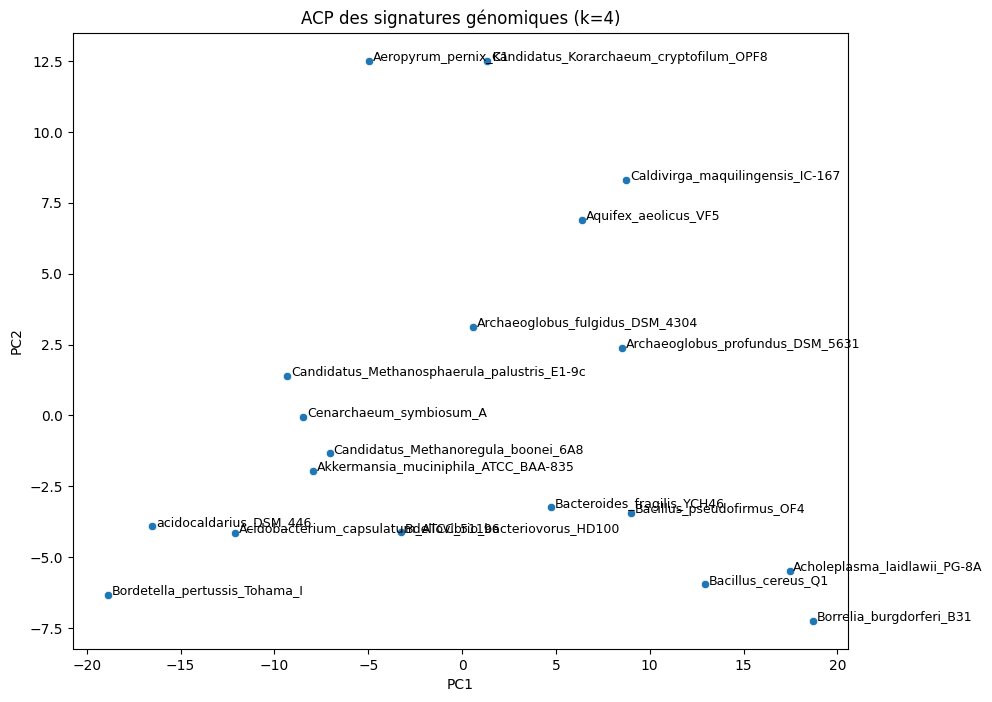

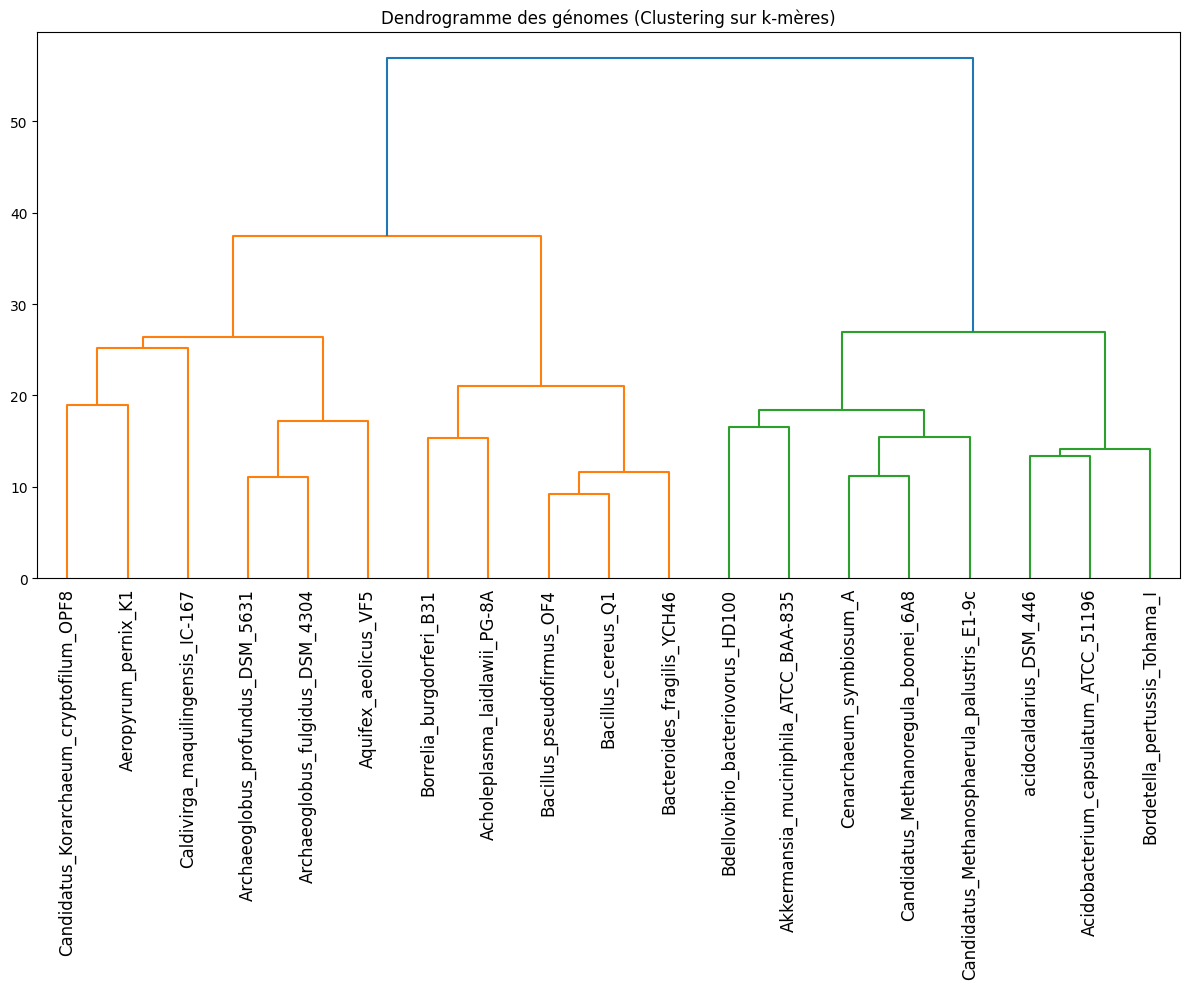

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage

# 1. Chargement des données
df = pd.read_csv('signatures_globales_k4.csv')
print(f"Dimensions : {df.shape}")

# On sépare les noms (labels) des données numériques
noms_organismes = df['Organisme'].values
data_numerique = df.drop('Organisme', axis=1)

# 2. Normalisation (StandardScaler)
# C'est souvent mieux pour l'ACP, bien que vos données soient déjà des fréquences
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_numerique)

# 3. ACP (PCA) - Visualisation globale
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(data_scaled)
pca_df = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])
pca_df['Organisme'] = noms_organismes

# --- NOTE : Ici, il faudrait idéalement ajouter une colonne 'Domaine' (Archée/Bactérie)
# --- pour colorer les points différemment. Pour l'instant, tout sera de la même couleur.

plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', data=pca_df)
# Pour ajouter les noms sur les points (peut être illisible si trop de points)
for i in range(pca_df.shape[0]):
    plt.text(pca_df.PC1[i]+0.2, pca_df.PC2[i], pca_df.Organisme[i], fontsize=9)
plt.title('ACP des signatures génomiques (k=4)')
plt.show()

# 4. Clustering Hiérarchique (Dendrogramme)
# Méthode de Ward minimise la variance intra-cluster
linked = linkage(data_scaled, method='ward')

plt.figure(figsize=(12, 10))
dendrogram(linked,
            orientation='top',
            labels=noms_organismes,
            distance_sort='descending',
            show_leaf_counts=True)
plt.title('Dendrogramme des génomes (Clustering sur k-mères)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

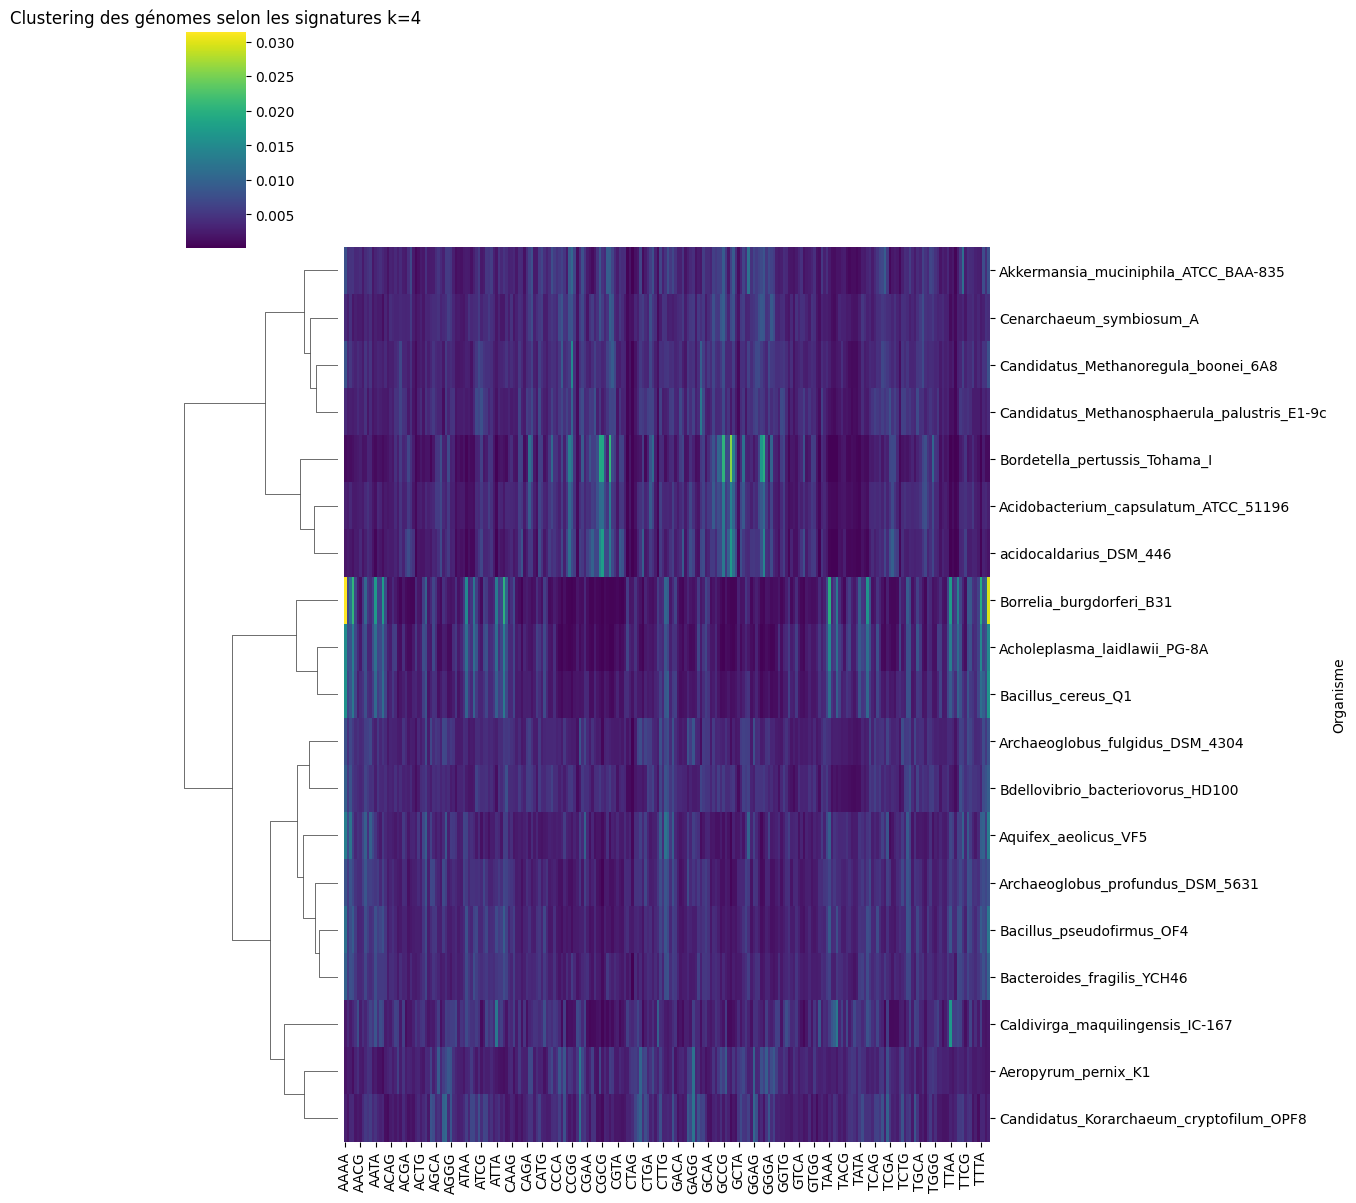

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

# 1. Charger les données
df = pd.read_csv('signatures_globales_k4.csv', index_col='Organisme')

# 2. & 3. Calcul du clustering (Méthode de Ward + Distance Euclidienne)
# La fonction clustermap de Seaborn fait tout ça automatiquement
g = sns.clustermap(df, 
                   method='ward', 
                   metric='euclidean', 
                   figsize=(12, 12), 
                   col_cluster=False, # On ne veut pas clusteriser les k-mers (colonnes), juste les espèces
                   cmap="viridis")

plt.title("Clustering des génomes selon les signatures k=4")
plt.show()

In [3]:
import os
from Bio import SeqIO
from itertools import product
import pandas as pd
import numpy as np

# 1. Paramètres
K = 4
TAILLE_FRAGMENT = 3000  # Taille du morceau d'ADN à analyser
mots_possibles = [''.join(c) for c in product('ATCG', repeat=K)]

def get_kmer_counts(sequence, k, all_kmers):
    """Compte les k-mères dans une séquence donnée"""
    # Dictionnaire vide initialisé à 0
    counts = {kmer: 0 for kmer in all_kmers}
    
    # Parcours de la séquence
    if len(sequence) < k:
        return list(counts.values())
        
    for i in range(len(sequence) - k + 1):
        kmer = sequence[i:i+k]
        if kmer in counts:
            counts[kmer] += 1
            
    # Normalisation (Fréquence)
    total = sum(counts.values())
    if total == 0: return list(counts.values())
    
    return [counts[kmer]/total for kmer in all_kmers]

# 2. Boucle sur les fichiers pour créer le Dataset
X = [] # Les signatures (features)
y = [] # Les labels (noms des génomes)

root_dir = "genomes" # Assurez-vous que c'est le bon chemin
print("Génération des fragments en cours...")

# Pour chaque dossier d'organisme
for organisme in os.listdir(root_dir):
    org_path = os.path.join(root_dir, organisme)
    if os.path.isdir(org_path):
        fasta_file = os.path.join(org_path, "genome.fasta")
        
        if os.path.exists(fasta_file):
            # Lecture du génome
            records = list(SeqIO.parse(fasta_file, "fasta"))
            if not records: continue
            
            # On concatène tous les chromosomes/plasmides en une seule séquence géante
            genome_seq = "".join([str(r.seq).upper() for r in records])
            
            # Découpage en fragments
            nb_fragments = len(genome_seq) // TAILLE_FRAGMENT
            # On limite à 100 fragments par génome pour équilibrer et aller vite
            # (Sinon les gros génomes écrasent les petits)
            nb_fragments = min(nb_fragments, 200) 
            
            for i in range(nb_fragments):
                start = i * TAILLE_FRAGMENT
                end = start + TAILLE_FRAGMENT
                sub_seq = genome_seq[start:end]
                
                # On ignore les fragments avec trop de "N" (inconnus)
                if sub_seq.count('N') > 50: continue
                
                # Calcul signature
                sig = get_kmer_counts(sub_seq, K, mots_possibles)
                
                X.append(sig)
                y.append(organisme)

print(f"Terminé ! {len(X)} fragments générés pour {len(set(y))} organismes.")

Génération des fragments en cours...
Terminé ! 3797 fragments générés pour 19 organismes.


In [11]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Conversion en tableaux numpy
X_array = np.array(X)
y_array = np.array(y)

# Séparation : 80% pour apprendre, 20% pour tester (simuler des gènes inconnus)
X_train, X_test, y_train, y_test = train_test_split(X_array, y_array, test_size=0.2, random_state=42)

print("Entraînement du réseau de neurones (MLP)...")

# MLPClassifier : Multi-Layer Perceptron
# hidden_layer_sizes=(100, 50) : 2 couches cachées de 100 et 50 neurones
clf = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)

clf.fit(X_train, y_train)

print("Entraînement terminé.")

# Évaluation
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Précision globale du modèle : {acc*100:.2f}%")

# Voir les détails par organisme
print("\nRapport détaillé :")
print(classification_report(y_test, y_pred))

Entraînement du réseau de neurones (MLP)...
Entraînement terminé.
Précision globale du modèle : 98.94%

Rapport détaillé :
                           precision    recall  f1-score   support

      Aeropyrum_pernix_K1       1.00      0.98      0.99        95
Bacillus_pseudofirmus_OF4       0.98      1.00      0.99        94

                 accuracy                           0.99       189
                macro avg       0.99      0.99      0.99       189
             weighted avg       0.99      0.99      0.99       189



In [10]:
from Bio import SeqIO
from itertools import product
import pandas as pd
import numpy as np
import os

# 1. Paramètres
K = 4
mots_possibles = [''.join(c) for c in product('ATCG', repeat=K)]

def get_kmer_counts(sequence, k, all_kmers):
    # (Même fonction que précédemment)
    counts = {kmer: 0 for kmer in all_kmers}
    if len(sequence) < k: return list(counts.values())
    for i in range(len(sequence) - k + 1):
        kmer = sequence[i:i+k]
        if kmer in counts: counts[kmer] += 1
    total = sum(counts.values())
    if total == 0: return list(counts.values())
    return [counts[kmer]/total for kmer in all_kmers]

# 2. Construction du Dataset
X = [] 
y = [] 

root_dir = "genomes"
print("Lecture des gènes annotés...")

for organism in os.listdir(root_dir):
    genes_file = os.path.join(root_dir, organism, "genes.fasta")
    
    if os.path.exists(genes_file):
        # On lit le fichier genes.fasta
        genes = list(SeqIO.parse(genes_file, "fasta"))
        
        # Pour éviter qu'un génome avec 5000 gènes écrase un génome avec 1000 gènes,
        # on peut limiter le nombre de gènes (Downsampling)
        # Prenons 500 gènes au hasard par organisme pour l'apprentissage
        import random
        if len(genes) > 500:
            genes_selectionnes = random.sample(genes, 500)
        else:
            genes_selectionnes = genes
            
        for gene in genes_selectionnes:
            seq = str(gene.seq).upper()
            
            # On ignore les gènes trop courts (moins informatifs) ou avec des "N"
            if len(seq) < 200 or 'N' in seq:
                continue
                
            sig = get_kmer_counts(seq, K, mots_possibles)
            X.append(sig)
            y.append(organism)

print(f"Dataset prêt : {len(X)} gènes chargés pour {len(set(y))} organismes.")

# Ensuite, vous pouvez lancer le même code de Réseau de Neurones (MLPClassifier) qu'avant.

Lecture des gènes annotés...
Dataset prêt : 945 gènes chargés pour 2 organismes.


In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Bio import SeqIO
from Bio.Seq import Seq
from itertools import product
from sklearn.model_selection import GroupShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# ---------------------
# 1. CONFIGURATION
# ---------------------
K = 4  # taille du k-mer
ROOT_DIR = "genomes"
LABEL_FILE = "genomes_labeled.txt"
MAX_GENES_PER_GENOME = 500  # downsampling
MIN_SEQ_LEN = 200           # gènes trop courts ignorés

FIG_DIR = "figures"
os.makedirs(FIG_DIR, exist_ok=True)

# ---------------------
# 2. GENERATE CANONICAL K-MERS
# ---------------------
def canonical_kmer(kmer):
    rc = str(Seq(kmer).reverse_complement())
    return min(kmer, rc)

# All possible canonical k-mers
all_kmers = [''.join(p) for p in product('ATCG', repeat=K)]
canonical_set = sorted(set(canonical_kmer(k) for k in all_kmers))

# ---------------------
# 3. K-MER COUNTS
# ---------------------
def get_kmer_counts(seq, k, canonical_kmers):
    seq = seq.upper()
    counts = {kmer: 0 for kmer in canonical_kmers}
    if len(seq) < k: return [0]*len(canonical_kmers)
    
    for i in range(len(seq) - k + 1):
        word = seq[i:i+k]
        if set(word) <= {'A','T','C','G'}:
            canon = canonical_kmer(word)
            counts[canon] += 1
    
    total = sum(counts.values())
    if total == 0: return [0]*len(canonical_kmers)
    return [counts[kmer]/total for kmer in canonical_kmers]

# ---------------------
# 4. LOAD LABELS
# ---------------------
labels_df = pd.read_csv(LABEL_FILE, names=["Organism", "Domain"])
labels_dict = dict(zip(labels_df["Organism"], labels_df["Domain"]))



Loading genes and computing k-mer signatures...


KeyError: 'Thermanaerovibrio_acidaminovorans_DSM_6589'

In [ ]:
# ---------------------
# 5. BUILD DATASET
# ---------------------
X = []
y = []
groups = []  # for GroupShuffleSplit

print("Loading genes and computing k-mer signatures...")

for organism in os.listdir(ROOT_DIR):
    genes_file = os.path.join(ROOT_DIR, organism, "cds.fasta")
    if not os.path.exists(genes_file):
        continue

    genes = list(SeqIO.parse(genes_file, "fasta"))
    if len(genes) > MAX_GENES_PER_GENOME:
        genes = random.sample(genes, MAX_GENES_PER_GENOME)

    for gene in genes:
        seq = str(gene.seq).upper()
        if len(seq) < MIN_SEQ_LEN or 'N' in seq:
            continue
        X.append(get_kmer_counts(seq, K, canonical_set))
        y.append(labels_dict[organism])
        groups.append(organism)

X = np.array(X)
y = np.array(y)
groups = np.array(groups)